# 05. recipes 패키지
https://recipes.tidymodels.org/index.html

https://www.tidymodels.org/learn/develop/recipes/

https://www.tidymodels.org/find/


In [2]:
library(tidyverse)
library(tidymodels)
ggplot2::theme_set(theme_bw())
tidymodels_prefer()

<br>

- 변수 엔지니어링에는 모델이 효과적으로 사용할 수 있도록 예측 변수 값의 형식을 다시 지정하는 작업이 수반
- 중요한 변수를 가장 잘 표현하기 위한 데이터 변환 및 인코딩이 포함

<br>

### Ames 데이터
- 공간 정보를 모델에 노출할 수 있는 방법에는 이웃(정성적 측정), 경도/위도, 가장 가까운 학교 또는 아이오와 주립대학교까지의 거리 등이 포함
- 모델링에서 이러한 데이터를 인코딩하는 방법을 선택할 때 결과와 가장 관련이 있다고 생각되는 옵션을 선택

In [4]:
ames <- ames %>% mutate(Sale_Price = log10(Sale_Price))
set.seed(20221010)
ames_split <- initial_split(ames, prop = 0.8, strata = Sale_Price)
ames_train <- training(ames_split)
ames_test <- testing(ames_split)

<br>

#### 더 나은 모델링 기능을 구축하기 위한 전처리의 다른 예
- 차원 축소 또는 일부 예측변수 제거를 통해 변수 간의 상관관계를 감소시킴
- 설명변수에 결측값이 있는 경우, 하위 모델을 사용하여 귀속
- 왜도가 크거나 작은 변수에 대한 로그/지수 변환
- 상이한 단위를 가진 수치형 변수들의 정규화/표준화



<br>

## 05.01 `recipes`

<br>

#### 데이터 변수
- `Neighborhood` : 이웃 (범주형)
- `Gr_Liv_Area` : 위층 생활 면적 (수치형)
- `Year_Built` : 건축연도 (수치형)
- `Bldg_Type` : 건물유형 (범주형)

<br>

#### `recipes`는 데이터 처리를 위한 일련의 단계를 정의하는 개체
- `step_*()` 문의 함수를 즉시 실행하지 않고, 단계를 정의

<br>

- `recipe` 객체에 변수정의 
    
    $\rightarrow$ 로그변환 단계 정의
    
    $\rightarrow$ 모든 명목형 변수에 대한 (`all_nominal_predictors()`) 더미변환 단계 정의
    

In [5]:
simple_ames <- recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type,
           data = ames_train) %>%
    step_log(Gr_Liv_Area, base = 10) %>% 
    step_dummy(all_nominal_predictors())
simple_ames



── Recipe ──────────────────────────────────────────────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 4



── Operations 

• Log transformation on: Gr_Liv_Area

• Dummy variables from: all_nominal_predictors()



<br>

## 05.02. `recipes` 사용
- **전처리 선택과 변수 엔지니어링은 일반적으로, 모델링 워크플로의 일부로 간주되어야 함**

<br>

- 모델 정의 및 워크플로 생성

In [6]:
lm_model <- linear_reg() %>%
    set_engine("lm")

lm_wflow <- workflow() %>%
    add_model(lm_model)


- 워크플로에 `recipes` 추가

In [7]:
lm_wflow <- lm_wflow %>%
    remove_variables() %>%
    add_recipe(simple_ames)
lm_wflow

Warning message:
"The workflow has no variables preprocessor to remove."


══ Workflow ════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_log()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────────────────────────────────────────────
Linear Regression Model Specification (regression)

Computational engine: lm 


<br>

- 데이터 적합 및 예측

In [8]:
lm_fit <- fit(lm_wflow, ames_train)
predict(lm_fit, ames_test %>% slice(1:3))

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response", :
"prediction from rank-deficient fit; consider predict(., rankdeficient="NA")"


.pred
<dbl>
0.7297171
0.7111743
0.6970430


<br>

- `recipe` 객체 추출

#### `extract_recipe()`

In [9]:
lm_fit %>% extract_recipe() 



── Recipe ──────────────────────────────────────────────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 4



── Training information 

Training data contained 2342 data points and no incomplete rows.



── Operations 

• Log transformation on: Gr_Liv_Area | Trained

• Dummy variables from: Neighborhood and Bldg_Type | Trained



<br>

- 적합 결과 추출

#### `extract_fit_parsnip()`

In [10]:
lm_fit %>% extract_fit_parsnip() %>%
    tidy() %>% slice(1:5)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.217538128,1.861768e-02,11.684492,1.098611e-30
Gr_Liv_Area,0.052679413,1.125252e-03,46.815656,0.000000e+00
Year_Built,0.000169396,9.417602e-06,17.987171,8.437528e-68
Neighborhood_College_Creek,0.001172431,6.543981e-04,1.791618,7.332514e-02
Neighborhood_Old_Town,-0.002563072,6.699108e-04,-3.825990,1.337055e-04


<br>

## 05.03. `recipe()` 단계의 예

<br>

#### 전처리 요소
- 0 및 거의 0에 가까운 분산 변수는 제거해야 할 낮은 결과
- 특성이 단일 고유 값만 포함한다는 의미의 제로 분산 변수는 모델에 유용한 정보를 제공하지 않는다.

<br>


#### Normalization
- ```step_center(var)``` - 평균을 빼서 중심 이동
- ```step_normalize(var)``` - 평균 빼고, 분산으로 나눠서 표준화

<br> 

#### Filters
- ```step_corr(threshold = 0.9)``` - 상관계수 절대값이 큰 변수 제거

- ```step_rm(var)``` - 변수 제거

- ```step_zv()``` - 분산이 0인 변수 제거

- ```step_nzv()``` - 분산이 거의 0인 변수 제거

<br> 

#### Transformations
- ```step_log(var, base = exp(1))``` - 로그 변환

- ```step_logit(var)``` - 로짓 변환

- ```step_poly(var, degree = 2)``` - 변수에 polynomial term 추가(glm에서 poly() 와 동일, 즉 orthogonal polynomial 이용)

- ```step_BoxCox()``` - Boxcox 변환

- ```step_YeoJohnson()``` - YeoJohnson 변환

<br> 

#### Discretization

- ```step_discretize(var, num_breaks = 4)``` - 연속형 변수 이산형으로 변환

- ```step_cut()``` - 연속형 변수를 지정한 값을 기준으로 이산형으로 변환
    -include_outside_range - 지정한 범위를 넘어선 값을 양끝 break에 포함시킬지 여부. default = FALSE이며 결측치 처리됨
    - breaks - 절단 기준이 되는 값

<br> 

#### Dummy variables and encodings
- ```step_string2factor()``` - 문자를 요인형으로

- ```step_date()``` - date 변수에서 year, month, day of week 변수를 새롭게 생성
    - feature = c(‘dow’, ‘month’, ‘year’) - 요일, 달, 연도 변수 추가
    - abbr = T - Sunday or Sun
    - label = Sunday or number

- ```step_holiday()``` - date 변수에서 공휴일에 관한 이진변수 새롭게 생성
    - holidays = c(‘LaborDay’, ‘NewYearDay’, ‘ChristmasDay’)
    - holidays = timeDate::listHolidays(‘US’)

- ```step_dummy()``` - character or factor 변수를 더미변수로 변환
    - one_hot = TRUE - C +1개의 더미변수 생성(one_hot = F: C-1개 더미변수 생성
- ```step_other()``` - 범주형 변수의 level이 여러개일 때, 하위 범주를 기타로 묶음
    - threshold = 0.05 - 하위 5% 범주는 기타로 묶임
    - other : 기타로 지정할 level 이름 지정

- ```step_interact(~ A:B)``` - 상호작용 항 추가

<br>

#### 상호작용
- ```step_interact(~ A:B)```

In [11]:
simple_ames <-  recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type,
                       data = ames_train) %>%
    step_log(Gr_Liv_Area, base = 10) %>% 
    step_other(Neighborhood, threshold = 0.01) %>% 
    step_dummy(all_nominal_predictors()) %>% 
    step_interact( ~ Gr_Liv_Area:starts_with("Bldg_Type_") )

<br>

#### 스플라인 함수
- 반응변수가 설명변수가 비선형 관계를 갖는 경우 스플라인 함수를 통하여 이 관계를 적응적으로 근사화할 수 있음. 
- 스플라인은 더 많은 스플라인 항이 데이터에 추가될수록 관계를 비선형적으로 표현하는 능력이 증가
- **하지만 데이터 추세(즉, 과적합)를 포착할 가능성도 증가**

In [12]:
library(patchwork)
library(splines)

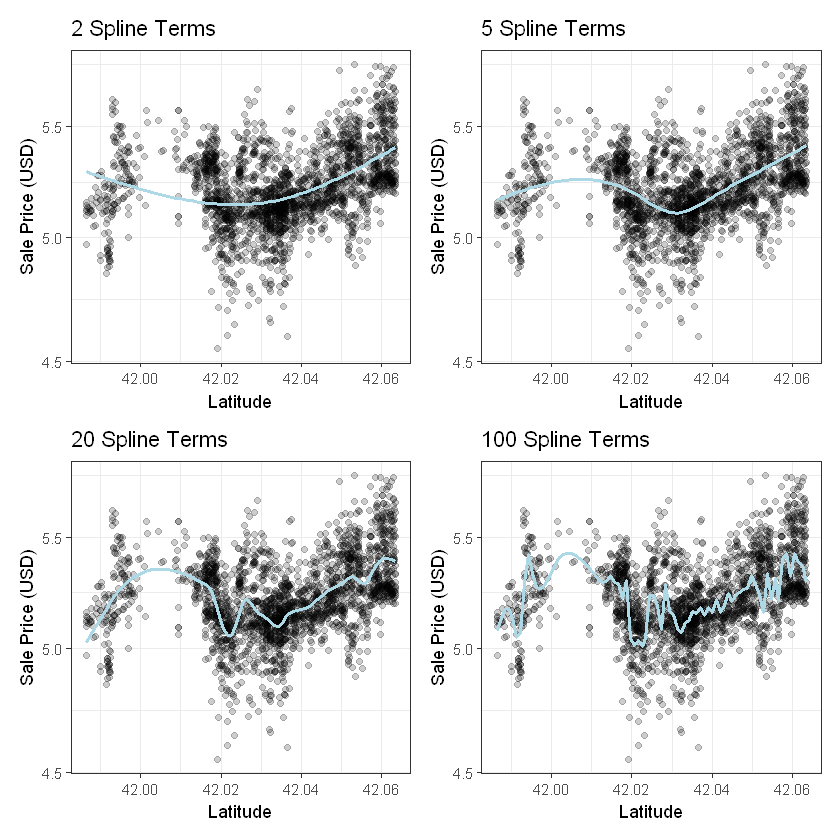

In [13]:
plot_smoother <- function(deg_free) {
    ggplot(ames_train, aes(Latitude, 10^Sale_Price)) + 
        geom_point(alpha = .2) + 
        scale_y_log10() +
        geom_smooth(
            method = lm,
            formula = y ~ ns(x, df = deg_free),
            color = "lightblue",
            se = FALSE
        ) + 
        labs(title = paste(deg_free, "Spline Terms"),
             y = "Sale Price (USD)")
}

(plot_smoother(2) + plot_smoother(5)) / (plot_smoother(20) + plot_smoother(100))

<br>

#### ```step_ns(변수, deg_free)``` : 자연 스플라인함수

<br>

1. `Gr_Liv_Area` 변수에 대한 로그변환
2. `Neighborhood` 범주형 변수의 하위 변수를 통일
3. 모든 범주형 변수에 대한 가변수화
4. `Gr_Liv_Area`와 `Bldg_Type_`로 시작하는 모든 변수들의 상호작용항 생성
5. `Latitude` 변수에 대한 자연 스플라인 함수 적용


In [14]:
recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + Latitude,
       data = ames_train) %>%
    step_log(Gr_Liv_Area, base = 10) %>% 
    step_other(Neighborhood, threshold = 0.01) %>% 
    step_dummy(all_nominal_predictors()) %>% 
    step_interact( ~ Gr_Liv_Area:starts_with("Bldg_Type_") ) %>% 
    step_ns(Latitude, deg_free = 20)



── Recipe ──────────────────────────────────────────────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 5



── Operations 

• Log transformation on: Gr_Liv_Area

• Collapsing factor levels for: Neighborhood

• Dummy variables from: all_nominal_predictors()

• Interactions with: Gr_Liv_Area:starts_with("Bldg_Type_")

• Natural splines on: Latitude



<br>

### 차원축소
- **여러 변수를 한 번에 표현하는 또 다른 일반적인 방법은 차원축소**
- 더 넓은 집합의 정보를 전체적으로 포착하는 예측 변수로부터 새로운 변수를 생성
    - 주성분 분석(PCA)은 선형 추출 방법. 각각의 새로운 변수는 원래 예측 변수의 선형 조
    
        PCA의 한 가지 좋은 측면은 주성분 또는 PCA 점수라고 불리는 각각의 새로운 기능이 서로 상관되지 않는다는 것
        
        이 때문에 PCA는 예측 변수 간의 상관 관계를 줄이는 데 매우 효과
        
        

<br>

#### ```step_pca()``` : 주성분 분석
#### ```step_ica()``` : 독립 성분 분석
#### ```step_nnmf()``` : 비음수 행렬 분해
#### ```step_isomap()``` : 다차원 척도 분석
#### ```step_umap()``` : 균일한 다양체 근사 및 투영

<br>


### 데이터 샘플링 
- 클래스 불균형에 대한 서브샘플링은 모델에 제공되는 데이터의 클래스 비율을 변경
    - 이러한 기술은 전체 성능을 향상시키지 못하는 경우가 많지만, 예측 변수 클래스 확률의 더 나은 분포를 생성할 수 있음. 

- **다운 샘플링 : 소수 클래스는 유지되고 다수 클래스의 무작위 샘플 추출**


#### ```step_downsample()```


<br>

- **업 샘플링 : 소수 클래스의 샘플을 복제하여 클래스의 균형을 유지**

#### ```step_upsample()```
#### ```step_adasyn()``` : 소수 클래스 데이터와 그 데이터에서 가장 가까운 k개의 소수 클래스 데이터 중 무작위로 선택된 데이터 사이의 직선상에 가상의 소수 클래스 데이터를 생성
#### ```step_bsmote()```
#### ```step_smote()```

<br>

- **하이브리드 : 다운 샘플링과 업 샘플링을 조합**

#### ```step_tomek()```
#### ```step_smotenc()```

<br>

#### 일반 샘플링
#### ```step_sample()```



<br> 

#### 기타 샘플링

#### ```step_filter()```
#### ```step_slice()``` 
#### ```step_arrange()```
#### ```step_naomit()```

<br>

### 일반 변환
#### ```step_mutate()``` : `dplyr::mutate()`를 `recipe` 단계에서 적용

<br>

### 자연어 처리
https://textrecipes.tidymodels.org/index.html


In [15]:
library(textrecipes)
library(stopwords)

In [16]:
data("tate_text")

In [17]:
tate_text %>% head()
tate_text %>% dim

id,artist,title,medium,year
<dbl>,<fct>,<chr>,<fct>,<dbl>
21926,Absalon,Proposals for a Habitat,"Video, monitor or projection, colour and sound (stereo)",1990
20472,"Auerbach, Frank",Michael,Etching on paper,1990
20474,"Auerbach, Frank",Geoffrey,Etching on paper,1990
20473,"Auerbach, Frank",Jake,Etching on paper,1990
20513,"Auerbach, Frank",To the Studios,Oil paint on canvas,1990
21389,"Ayres, OBE Gillian",Phaëthon,Oil paint on canvas,1990


[1] 4284    5

In [18]:
okc_rec <- recipe(~ medium + artist, data = tate_text) %>%
    step_tokenize(medium, artist) %>%
    step_stopwords(medium, artist) %>%
    step_tokenfilter(medium, artist, max_tokens = 10) %>%
    step_tfidf(medium, artist)

okc_obj <- okc_rec %>% prep()

In [19]:
bake(okc_obj, tate_text) %>% head()
bake(okc_obj, tate_text) %>% dim

tfidf_medium_colour,tfidf_medium_etching,tfidf_medium_gelatin,tfidf_medium_lithograph,tfidf_medium_paint,tfidf_medium_paper,tfidf_medium_photograph,tfidf_medium_print,tfidf_medium_screenprint,tfidf_medium_silver,tfidf_artist_akram,tfidf_artist_beuys,tfidf_artist_ferrari,tfidf_artist_john,tfidf_artist_joseph,tfidf_artist_león,tfidf_artist_richard,tfidf_artist_schütte,tfidf_artist_thomas,tfidf_artist_zaatari
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2.314009,0.0000000,0,0,0.000000,0.0000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0.000000,0.8601965,0,0,0.000000,0.4217902,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0.000000,0.8601965,0,0,0.000000,0.4217902,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0.000000,0.8601965,0,0,0.000000,0.4217902,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0.000000,0.0000000,0,0,2.353278,0.0000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0.000000,0.0000000,0,0,2.353278,0.0000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0


[1] 4284   20

<br>

## 05.05. Tidy a recipe
- **모든 ```step_*```에서 ```id```지정 가능**
    - ```id```를 설정하면, 동일한 recpipe의 step이 두 번 이상 사용되는 경우 식별 가능

<br>

- 각 `recipe` 단계별 `id` 주기

In [27]:
ames_rec <- recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + 
           Latitude + Longitude, data = ames_train) %>%
  step_log(Gr_Liv_Area, base = 10) %>% 
  step_other(Neighborhood, threshold = 0.01, id = "my_id") %>% 
  step_dummy(all_nominal_predictors()) %>% 
  step_interact( ~ Gr_Liv_Area:starts_with("Bldg_Type_") ) %>% 
  step_ns(Latitude, Longitude, deg_free = 20)

In [28]:
tidy(ames_rec)

number,operation,type,trained,skip,id
<int>,<chr>,<chr>,<lgl>,<lgl>,<chr>
1,step,log,FALSE,FALSE,log_WpTEM
2,step,other,FALSE,FALSE,my_id
3,step,dummy,FALSE,FALSE,dummy_ykI1F
4,step,interact,FALSE,FALSE,interact_cmRNx
5,step,ns,FALSE,FALSE,ns_2VDh3


- 모델 정의

In [29]:
lm_model <- linear_reg() %>% set_engine("lm")

- 워크플로 생성 및 `recipie` 적용

In [30]:
lm_wflow <- workflow() %>%
    add_model(lm_model) %>%
    add_recipe(ames_rec)

- 모델 적합

In [31]:
lm_fit <- fit(lm_wflow, ames_train)

<br>

#### `extract_recipe()` : `id`를 통한 `recipe` 단계별 결과 확인
- `id = 'my_id'` : `step_pther` (하위 범주 통일) 결과 확인

In [35]:
estimated_recipe <- lm_fit %>%
    extract_recipe(estimated = TRUE)

tidy(estimated_recipe, id = "my_id")

terms,retained,id
<chr>,<chr>,<chr>
Neighborhood,North_Ames,my_id
Neighborhood,College_Creek,my_id
Neighborhood,Old_Town,my_id
Neighborhood,Edwards,my_id
Neighborhood,Somerset,my_id
Neighborhood,Northridge_Heights,my_id
Neighborhood,Gilbert,my_id
Neighborhood,Sawyer,my_id
Neighborhood,Northwest_Ames,my_id


<br>


## 05.06. 변수 역할 변경
#### ```add_role()``` : 이미 레시피에서 역할이 있는 변수에 추가 역할을 추가
#### ```remove_role()``` : 레시피에서 기존의 단일 역할을 제거
#### ```update_role()``` : 레시피의 기존 역할을 변경하거나 아직 선언된 역할이 없는 변수에 초기 역할을 할당

<br>

- **`HHV` : `outcome` (반응변수)**
- **그 외 변수 : `predictor` (설명변수)**

In [36]:
data(biomass, package = "modeldata")

In [37]:
recipe(HHV ~ ., data = biomass) %>% summary()

variable,type,role,source
<chr>,<list>,<chr>,<chr>
sample,"string , unordered, nominal",predictor,original
dataset,"string , unordered, nominal",predictor,original
carbon,"double , numeric",predictor,original
hydrogen,"double , numeric",predictor,original
oxygen,"double , numeric",predictor,original
nitrogen,"double , numeric",predictor,original
sulfur,"double , numeric",predictor,original
HHV,"double , numeric",outcome,original


<br>

- `sample` 변수를 인덱스로 (`id_variable`), `dataset` 변수를 학습/훈련 데이터 구분 변수로 역할 변경

In [41]:
recipe(HHV ~ ., data = biomass) %>%
  update_role(sample, new_role = "id variable") %>%
  update_role(dataset, new_role = "splitting variable") %>%
  summary()

variable,type,role,source
<chr>,<list>,<chr>,<chr>
sample,"string , unordered, nominal",id variable,original
dataset,"string , unordered, nominal",splitting variable,original
carbon,"double , numeric",predictor,original
hydrogen,"double , numeric",predictor,original
oxygen,"double , numeric",predictor,original
nitrogen,"double , numeric",predictor,original
sulfur,"double , numeric",predictor,original
HHV,"double , numeric",outcome,original
